In [1]:
import pandas as pd
from DataCleaning import DataCleaning
from EDA import EDA
from KFoldCrossValidation import KFoldCrossValidation
from LinearRegression import LinearRegression

### 1. First, the dataset needs to be loaded. For the sake of simplicity, we are gonna use an object for loading and cleaning the dataset.

In [2]:
data_cleaner = DataCleaning('assets/auto_train.csv')
df = data_cleaner.df
data_cleaner.show_head(df)


c:\Users\Luca Petrescu\Desktop\Master\Anul 1\Semestrul 2\DMDA\Curs\Tema 2\Assignment_2_Luca_Petrescu\vehicle_regresion\DataCleaning.py:13: DtypeWarning: Columns (41,56) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(self.file_path)


,id,data,nume,pret,url,Oferit de,Are VIN (Serie sasiu),Marca,Model,Versiune,...,Predare leasing,Plata initiala (la predare),Autonomie,Consum mediu,Capacitate baterie,Valoare rata lunara,Timp de incarcare,Numar de rate lunare ramase,Valoare reziduala,Consum Mixt
0,7053131628,2024-03-06 11:49:00,Volkswagen Tiguan 2.0 TDI 4Motion DSG Sport & ...,9999.0,https://www.autovit.ro/autoturisme/anunt/volks...,Firma,Da,Volkswagen,Tiguan,2.0 TDI 4Motion DSG Sport & Style,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7053116553,2024-03-06 11:37:00,Opel Astra,3150.0,https://www.autovit.ro/autoturisme/anunt/opel-...,Firma,NaN,Opel,Astra,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7052933182,2024-03-06 11:37:00,Dacia Duster,17790.0,https://www.autovit.ro/autoturisme/anunt/dacia...,Firma,Da,Dacia,Duster,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7053100111,2024-03-06 11:37:00,BMW X4 xDrive20d Aut. M Sport,24990.0,https://www.autovit.ro/autoturisme/anunt/bmw-x...,Firma,Da,BMW,X4,xDrive20d Aut. M Sport,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7053209893,2024-03-06 11:41:00,Dacia Duster dCi 110 4WD Prestige,9790.0,https://www.autovit.ro/autoturisme/anunt/dacia...,Privat,Da,Dacia,Duster,dCi 110 4WD Prestige,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 ##### 1. a. Checking the missing values
To understand the dataset, we need to se whick columns contain missing values

In [3]:
data_cleaner.get_nan_values(df)

id                                         0
data                                       0
nume                                       0
pret                                       0
url                                        0
Oferit de                                  0
Are VIN (Serie sasiu)                   8201
Marca                                      0
Model                                      0
Versiune                                4110
Anul producției                            0
Km                                        55
Combustibil                                0
Putere                                     7
Capacitate cilindrica                    554
Transmisie                              2184
Consum Extraurban                      11012
Cutie de viteze                            1
Consum Urban                            6150
Tip Caroserie                              0
Emisii CO2                              9621
Numar de portiere                        181
Culoare   

##### 1. b. Cleaning the dataset of NaN columns
We are gonna drop the columns where at least 2/3 of the data is missing.

In [4]:
df = data_cleaner.delete_columns_with_nans(df)

Deleted column 'sau in limita a' with 16600 NaN values (more than 66.0% of the rows)
Deleted column 'Garantie dealer (inclusa in pret)' with 14079 NaN values (more than 66.0% of the rows)
Deleted column 'Garantie de la producator pana la' with 18310 NaN values (more than 66.0% of the rows)
Deleted column 'Vehicule electrice' with 16811 NaN values (more than 66.0% of the rows)
Deleted column 'Tuning' with 19313 NaN values (more than 66.0% of the rows)
Deleted column 'Contract baterie' with 19273 NaN values (more than 66.0% of the rows)
Deleted column 'Masina de epoca' with 19481 NaN values (more than 66.0% of the rows)
Deleted column 'Volan pe dreapta' with 19465 NaN values (more than 66.0% of the rows)
Deleted column 'Predare leasing' with 19397 NaN values (more than 66.0% of the rows)
Deleted column 'Plata initiala (la predare)' with 19471 NaN values (more than 66.0% of the rows)
Deleted column 'Autonomie' with 19175 NaN values (more than 66.0% of the rows)
Deleted column 'Consum medi

##### 1. c. Check the rest of the missing values in the columns

To see what has to be done next in the cleaning phase, wee need to see which columns have missing values. We are gonna do that for both numerical and object columns

##### Checking the numerical data

In [5]:
numeric_columns = data_cleaner.df.select_dtypes(include=['number'])
numeric_columns_with_nan = numeric_columns.columns[numeric_columns.isna().any()].tolist()
numeric_df_with_nan = df[numeric_columns_with_nan]
numeric_df_with_nan.info()
numeric_dataframe = pd.DataFrame(numeric_df_with_nan)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19526 entries, 0 to 19525
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Km                     19471 non-null  float64
 1   Putere                 19519 non-null  float64
 2   Capacitate cilindrica  18972 non-null  float64
 3   Consum Extraurban      8514 non-null   float64
 4   Consum Urban           13376 non-null  float64
 5   Emisii CO2             9905 non-null   float64
 6   Numar de portiere      19345 non-null  float64
 7   Numar locuri           15264 non-null  float64
dtypes: float64(8)
memory usage: 1.2 MB


##### Checking the object data

In [6]:
object_columns = data_cleaner.df.select_dtypes(include=['object'])
object_columns_with_nan = object_columns.columns[object_columns.isna().any()].tolist()
object_df_with_nan = df[object_columns_with_nan]
object_df_with_nan.info()
object_dataframe = pd.DataFrame(object_df_with_nan)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19526 entries, 0 to 19525
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Are VIN (Serie sasiu)                11325 non-null  object
 1   Versiune                             15416 non-null  object
 2   Transmisie                           17342 non-null  object
 3   Cutie de viteze                      19525 non-null  object
 4   Se emite factura                     9541 non-null   object
 5   Eligibil pentru finantare            9428 non-null   object
 6   Primul proprietar (de nou)           8066 non-null   object
 7   Fara accident in istoric             12135 non-null  object
 8   Carte de service                     12272 non-null  object
 9   VIN (serie sasiu)                    11330 non-null  object
 10  Audio si tehnologie                  18980 non-null  object
 11  Confort si echipamente optionale     1939

##### 1. d. Filling the missing numeric data

The numerical data will be filled with the median of the columns

In [7]:
df = data_cleaner.fill_nan_with_median(df)
object_df_with_nan.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19526 entries, 0 to 19525
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   Are VIN (Serie sasiu)                11325 non-null  object
 1   Versiune                             15416 non-null  object
 2   Transmisie                           17342 non-null  object
 3   Cutie de viteze                      19525 non-null  object
 4   Se emite factura                     9541 non-null   object
 5   Eligibil pentru finantare            9428 non-null   object
 6   Primul proprietar (de nou)           8066 non-null   object
 7   Fara accident in istoric             12135 non-null  object
 8   Carte de service                     12272 non-null  object
 9   VIN (serie sasiu)                    11330 non-null  object
 10  Audio si tehnologie                  18980 non-null  object
 11  Confort si echipamente optionale     1939

c:\Users\Luca Petrescu\Desktop\Master\Anul 1\Semestrul 2\DMDA\Curs\Tema 2\Assignment_2_Luca_Petrescu\vehicle_regresion\DataCleaning.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)


##### 1. e. Dealing with categorical data

First, wee need to se what columns contain categorical data

In [8]:
data_cleaner.detect_categorical_data(df)

Column 'Oferit de' is categorical with 2 unique values.
Column 'Are VIN (Serie sasiu)' is categorical with 1 unique values.
Column 'Transmisie' is categorical with 4 unique values.
Column 'Cutie de viteze' is categorical with 2 unique values.
Column 'Se emite factura' is categorical with 1 unique values.
Column 'Eligibil pentru finantare' is categorical with 1 unique values.
Column 'Primul proprietar (de nou)' is categorical with 1 unique values.
Column 'Fara accident in istoric' is categorical with 1 unique values.
Column 'Carte de service' is categorical with 1 unique values.
Column 'Stare' is categorical with 2 unique values.
Column 'VIN (serie sasiu)' is categorical with 1 unique values.
Column 'Optiuni culoare' is categorical with 3 unique values.
Column 'Inmatriculat' is categorical with 1 unique values.


['Oferit de',
 'Are VIN (Serie sasiu)',
 'Transmisie',
 'Cutie de viteze',
 'Se emite factura',
 'Eligibil pentru finantare',
 'Primul proprietar (de nou)',
 'Fara accident in istoric',
 'Carte de service',
 'Stare',
 'VIN (serie sasiu)',
 'Optiuni culoare',
 'Inmatriculat']

We will now fill the categorical data with the most frequent values in those columns

In [9]:
df = data_cleaner.fill_nan_with_frequent(df)

For column 'Are VIN (Serie sasiu)', filled NaN with 'Da'
For column 'Versiune', filled NaN with 'xDrive30d'
For column 'Transmisie', filled NaN with 'Fata'
For column 'Cutie de viteze', filled NaN with 'Automata'
For column 'Se emite factura', filled NaN with 'Da'
For column 'Eligibil pentru finantare', filled NaN with 'Da'
For column 'Primul proprietar (de nou)', filled NaN with 'Da'
For column 'Fara accident in istoric', filled NaN with 'Da'
For column 'Carte de service', filled NaN with 'Da'
For column 'VIN (serie sasiu)', filled NaN with 'Vezi VIN-ul (seria de sasiu)'
For column 'Audio si tehnologie', filled NaN with '['Radio']'
For column 'Confort si echipamente optionale', filled NaN with '['Aer conditionat', 'Geamuri electrice fata', 'Geamuri electrice spate']'
For column 'Electronice si sisteme de asistenta', filled NaN with '['Servodirectie']'
For column 'Siguranta', filled NaN with '['ABS', 'ESP', 'EBD', 'Franare asistata', 'Airbag sofer', 'Airbag scaun pasager', 'Airbag-uri 

c:\Users\Luca Petrescu\Desktop\Master\Anul 1\Semestrul 2\DMDA\Curs\Tema 2\Assignment_2_Luca_Petrescu\vehicle_regresion\DataCleaning.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(most_frequent_value, inplace=True)


### 2. EDA

##### 2. a. Initializing EDA

In this part, we will take care of the EDA part. Because some of the columns are not relevant to the analysis, they will need to be dropped. Moving on, we need to plot de distribution based on the price column.

c:\Users\Luca Petrescu\Desktop\Master\Anul 1\Semestrul 2\DMDA\Curs\Tema 2\Assignment_2_Luca_Petrescu\vehicle_regresion\EDA.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['pret'], fit=norm)


0        7053131628
1        7053116553
2        7052933182
3        7053100111
4        7053209893
            ...    
19521    7053128100
19522    7053125121
19523    7053262542
19524    7051451034
19525    7053187847
Name: id, Length: 19526, dtype: int64


c:\Users\Luca Petrescu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


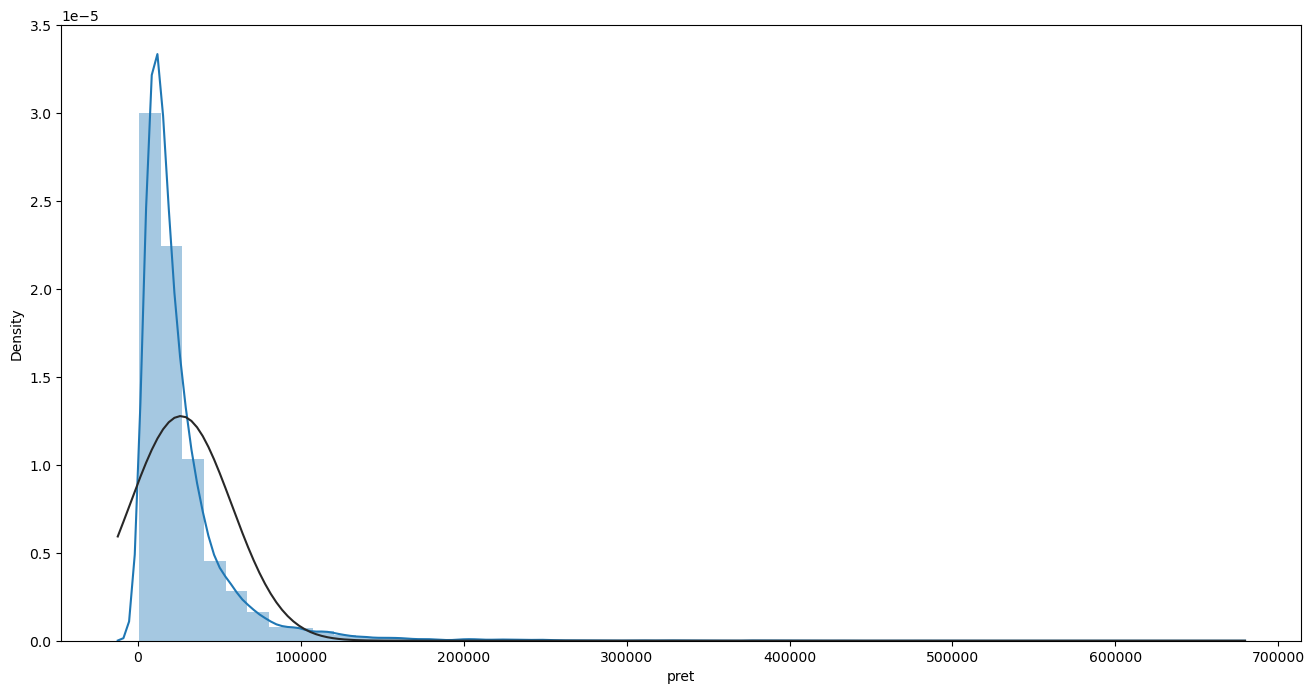

<Figure size 640x480 with 0 Axes>

In [10]:
car_ids = df["id"]
print(car_ids)
df = df.drop(columns=['id', 'data', 'url'])
EDA_analyzer = EDA(df)
EDA_analyzer.show_distribution(df)


#### 2. b. Detecting outliers in columns

We can see that the distribution does not resemble a classic distribution, so therefore, transformations are required. For this, we need to determine the outliers.

In [11]:
price_column = df['pret']
numeric_outliers = EDA_analyzer.detect_outliers(df)
for col, outliers in numeric_outliers.items():
    print(f"Outliers in column '{col}':")
    print(outliers)
    print()
column_list = list(numeric_outliers.keys())
print(column_list)

Outliers in column 'pret':
15        62951.0
56       106246.0
64        64248.0
87       129989.0
98        65900.0
           ...   
19507    250000.0
19509     87763.0
19511    146432.0
19516    285588.0
19517     79799.0
Name: pret, Length: 1479, dtype: float64

Outliers in column 'Anul producției':
1        2002
42       1992
151      2003
362      1999
439      2004
         ... 
18980    2004
19034    2002
19158    1999
19268    2001
19369    2003
Name: Anul producției, Length: 183, dtype: int64

Outliers in column 'Km':
983       588000.0
1530      602000.0
2546     2080288.0
2982      488894.0
3208      510000.0
3323      500000.0
4729      620000.0
4754      412000.0
4937      489094.0
5058      412817.0
5340      411000.0
5696      504000.0
5724      440000.0
5733      502883.0
5898      413769.0
5999      469000.0
6640      458000.0
7405      550000.0
7481      449884.0
8543      450000.0
8862      418180.0
8906      415000.0
8931      575000.0
9019      800000.0
9268      

#### 2. c. Plotting the outliers

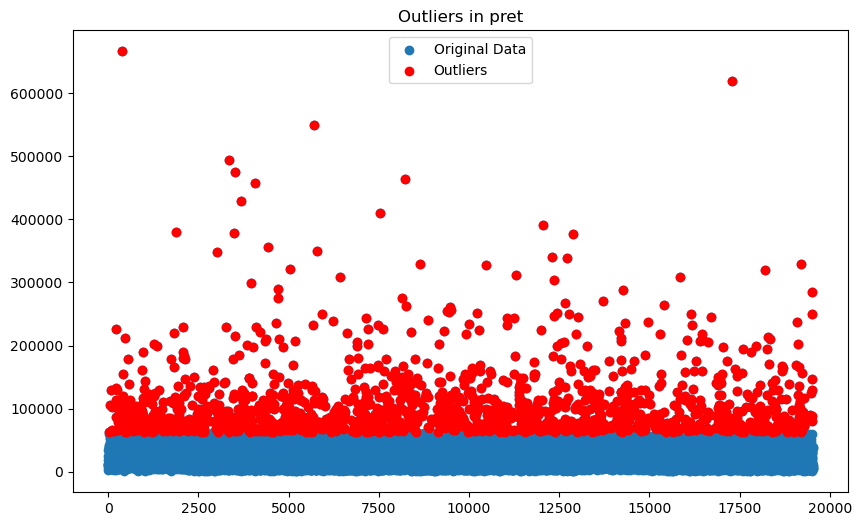

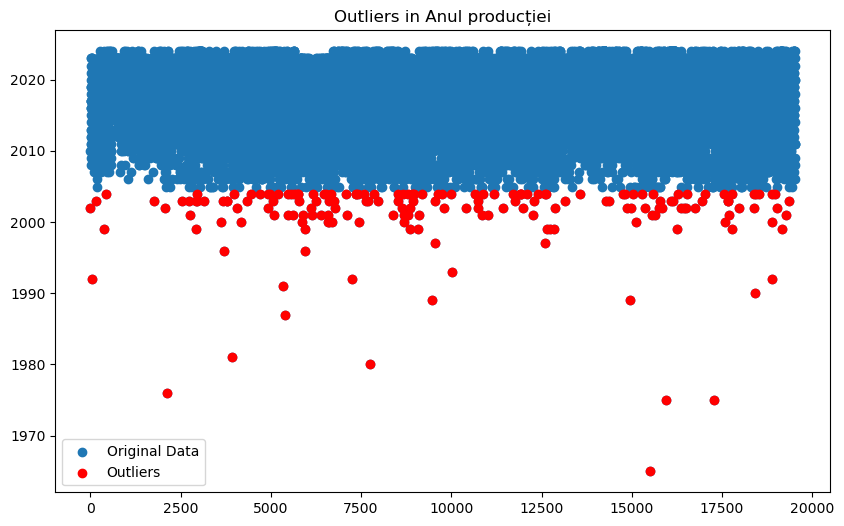

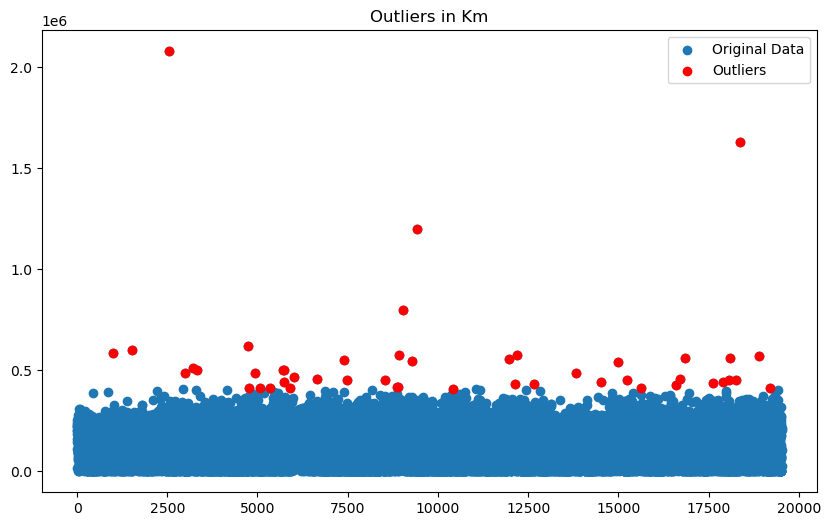

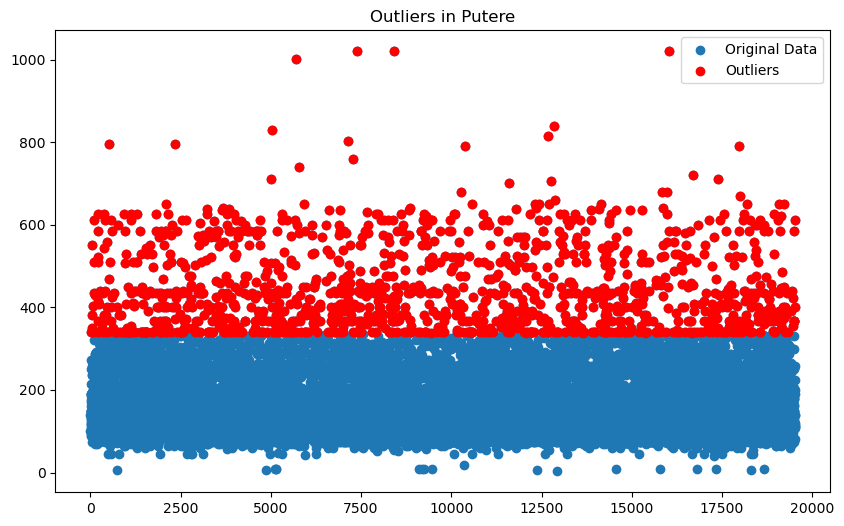

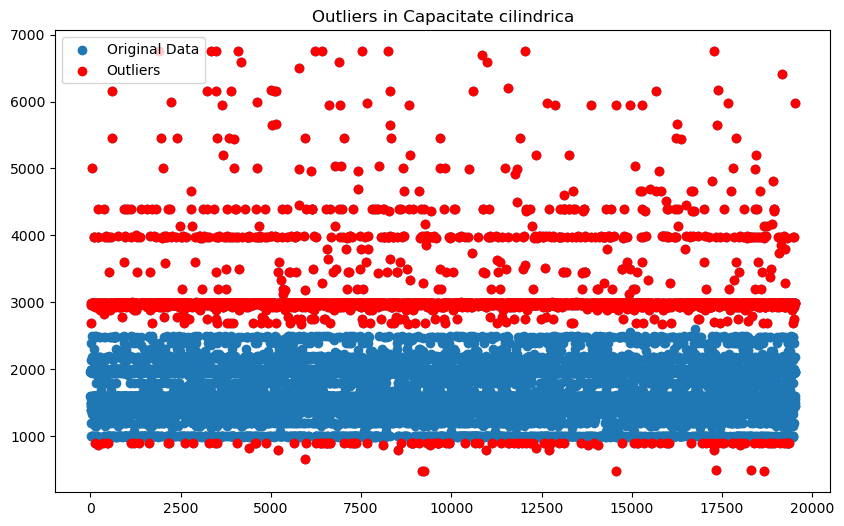

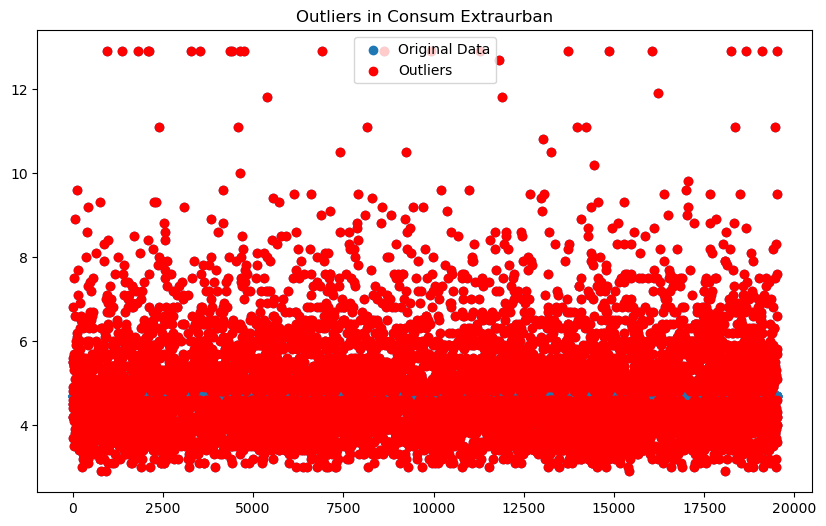

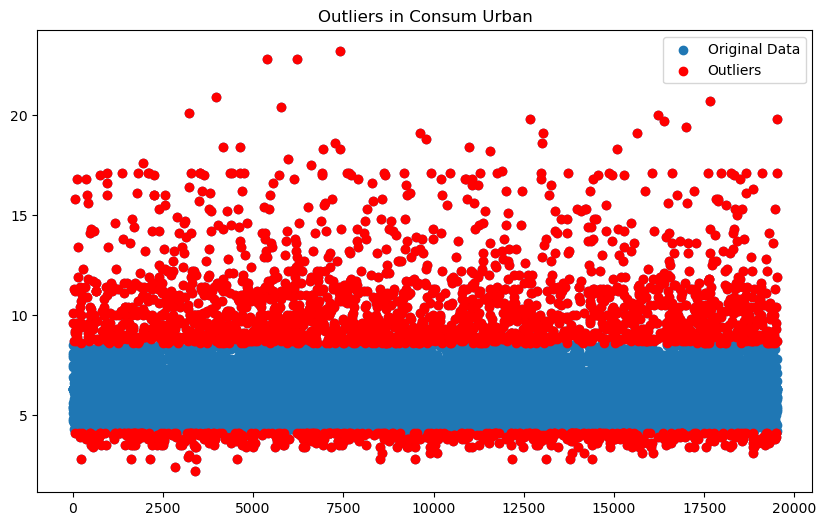

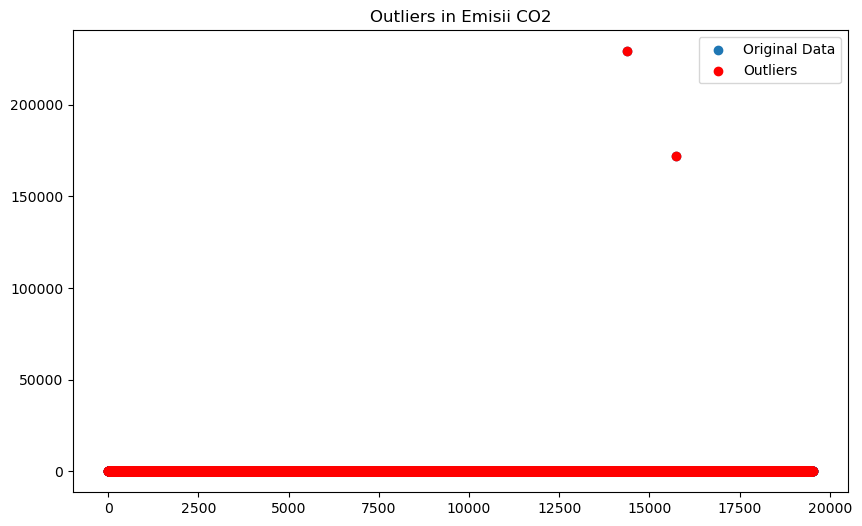

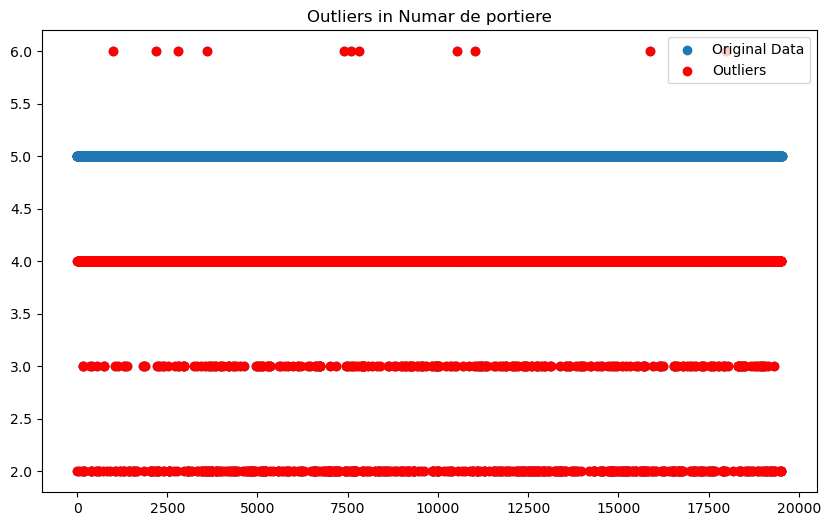

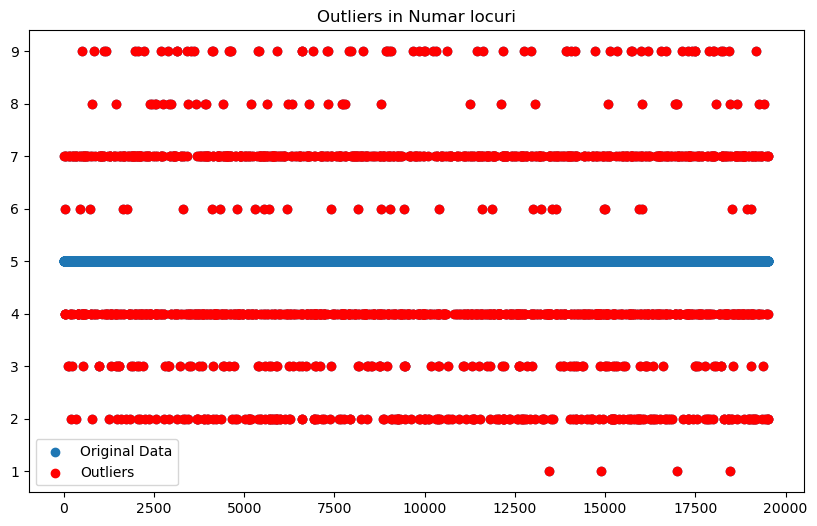

In [12]:
EDA_analyzer.plot_outliers(df, numeric_outliers)

#### 2. d. Applying the logarithmic transformations

For getting a better distribution, we need to apply the logarithmic distribution.

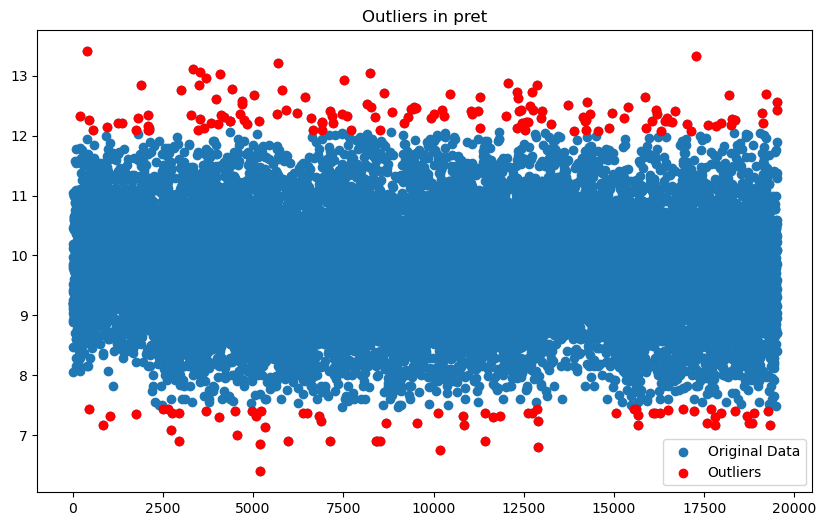

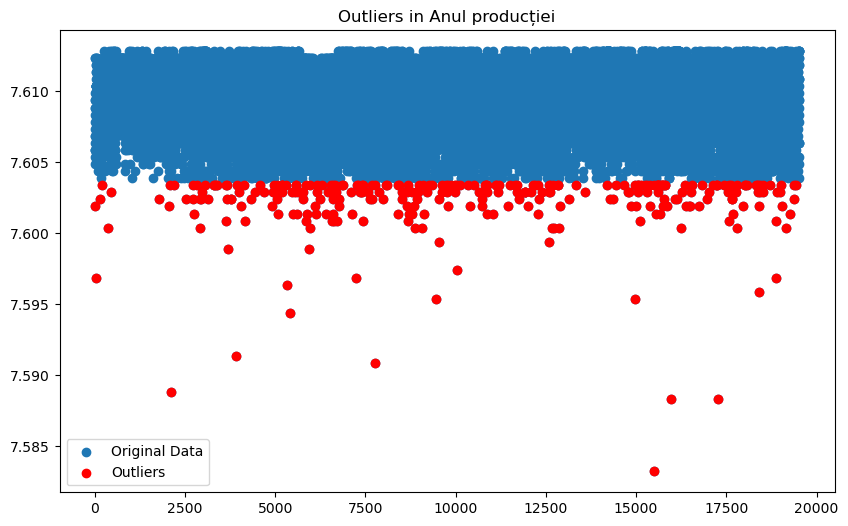

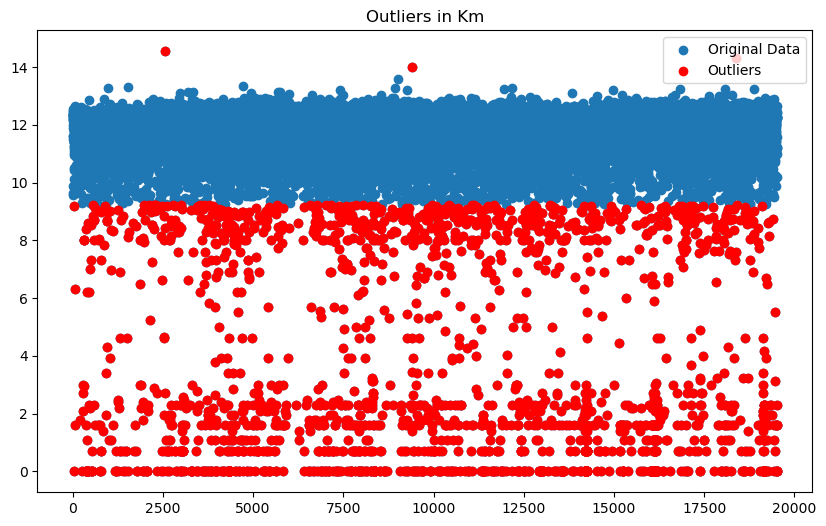

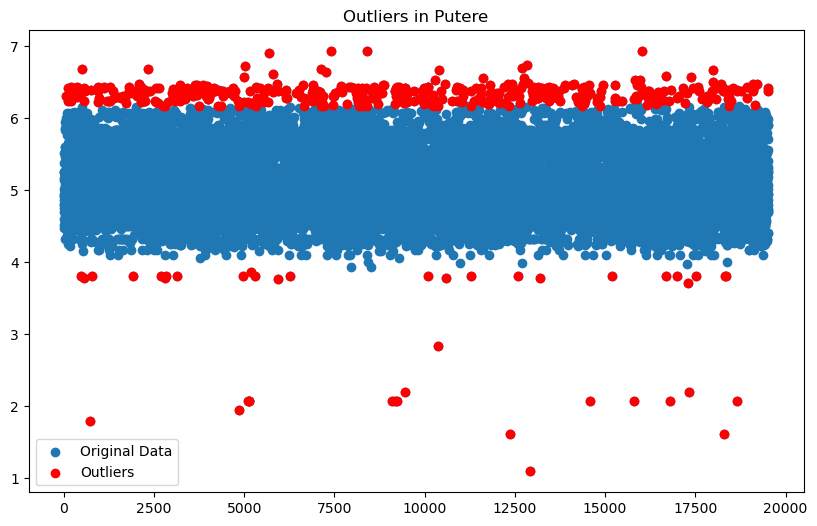

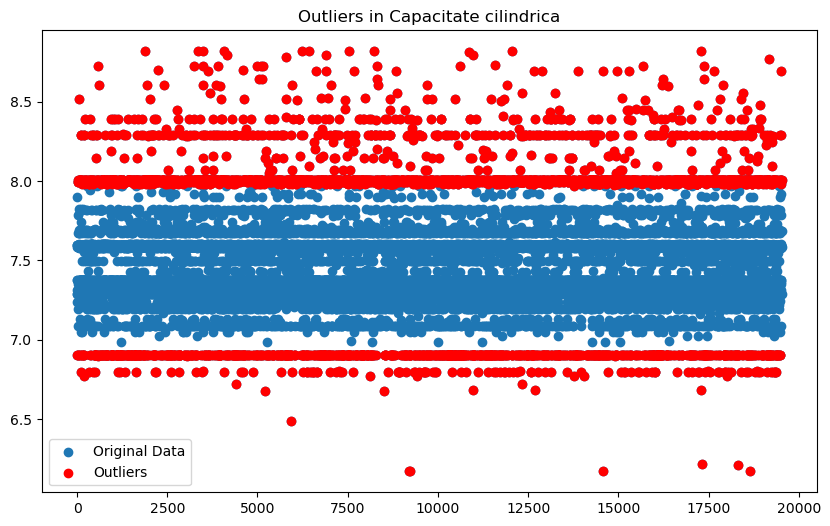

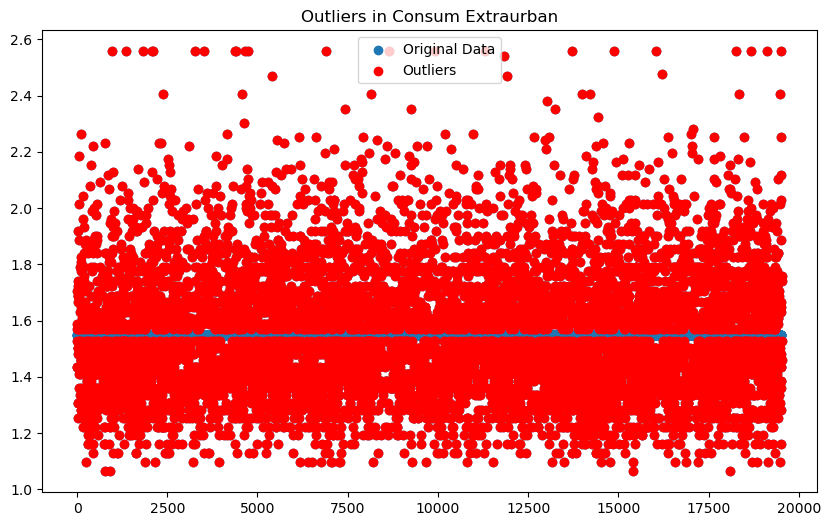

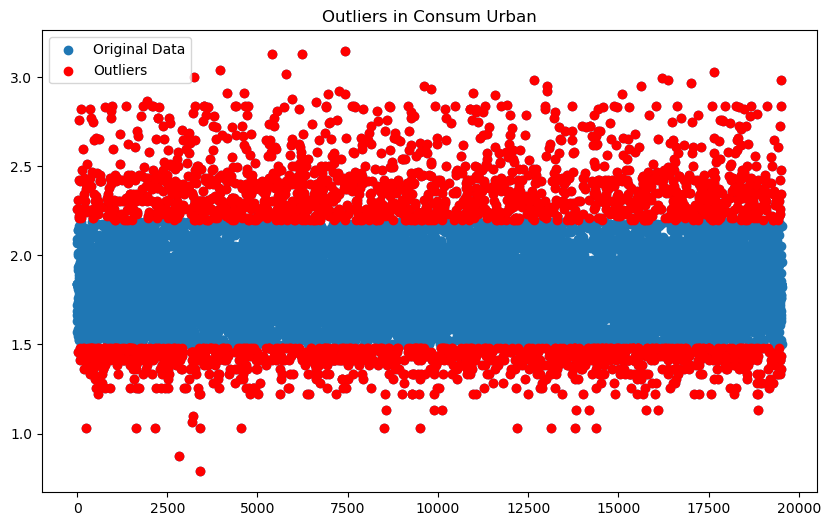

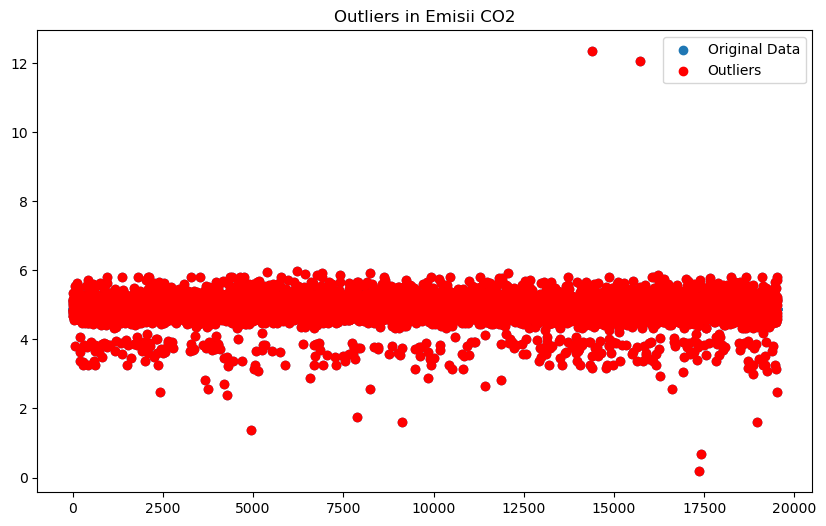

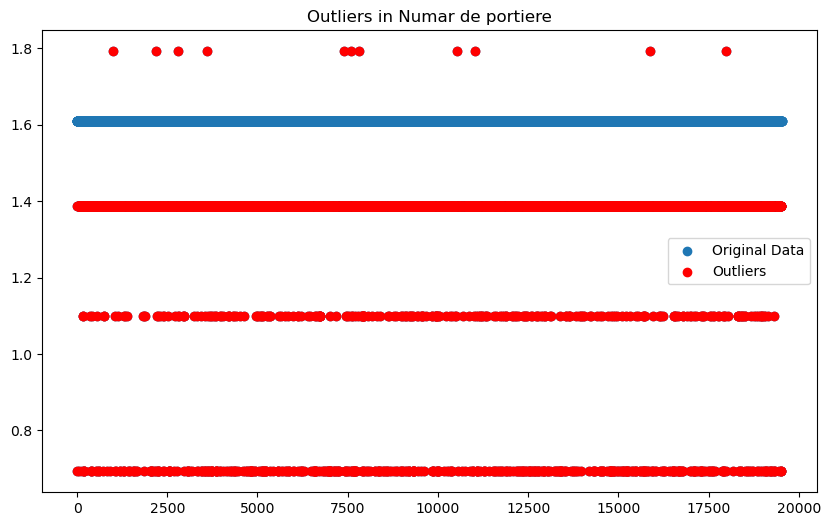

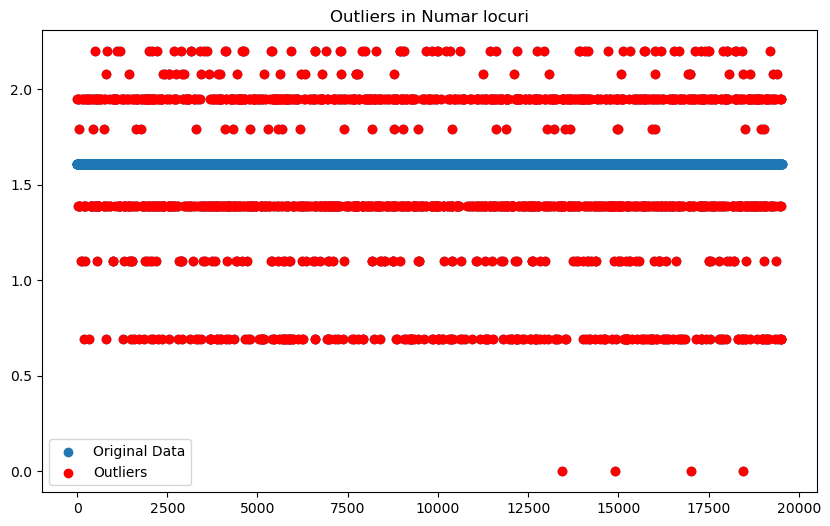

In [13]:
transformed_df = EDA_analyzer.apply_logarithmic(df, column_list)
column_list = EDA_analyzer.get_columns_names(transformed_df)
outliers_after = EDA_analyzer.detect_outliers(transformed_df)
EDA_analyzer.plot_outliers(transformed_df, outliers_after)

We can see here that the distribution now ressembles a classic distribution.

c:\Users\Luca Petrescu\Desktop\Master\Anul 1\Semestrul 2\DMDA\Curs\Tema 2\Assignment_2_Luca_Petrescu\vehicle_regresion\EDA.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['pret'], fit=norm)
c:\Users\Luca Petrescu\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


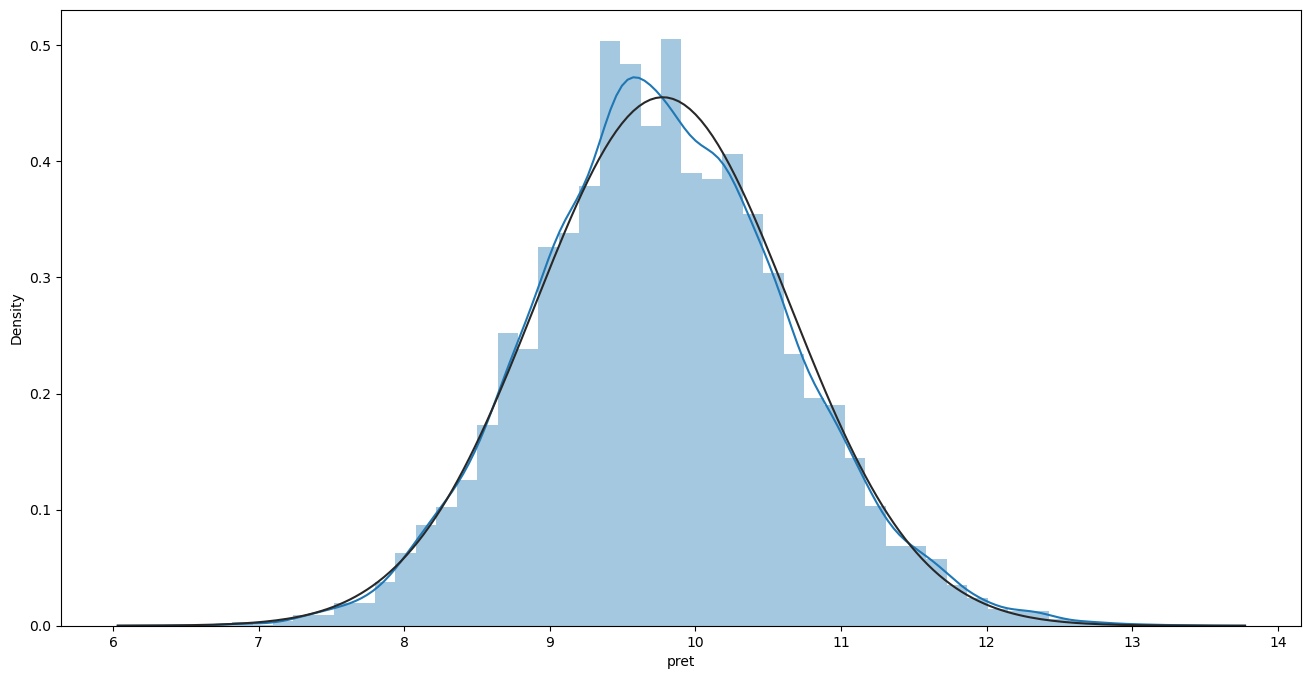

<Figure size 640x480 with 0 Axes>

In [14]:
EDA_analyzer.show_distribution(transformed_df)

#### 2. e. Plotting the data

In order to better understand the data, we need to plot it with the target variable, which in this case is the price.

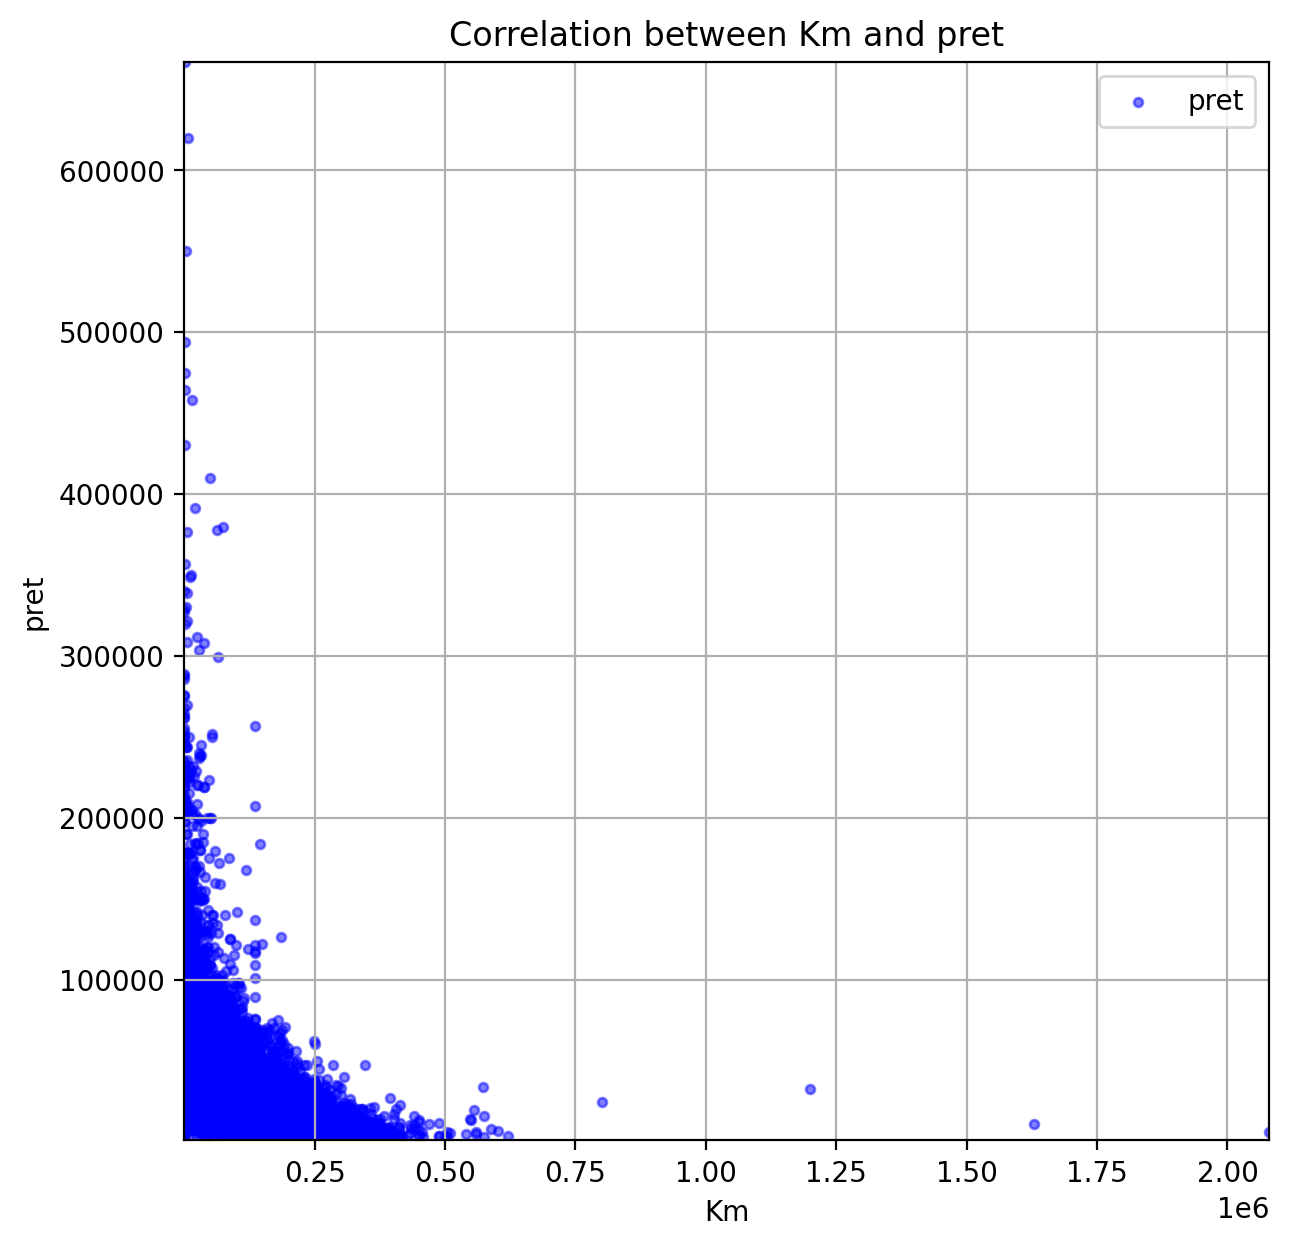

In [15]:
EDA_analyzer.plot_graph(df, 'Km', 'pret')

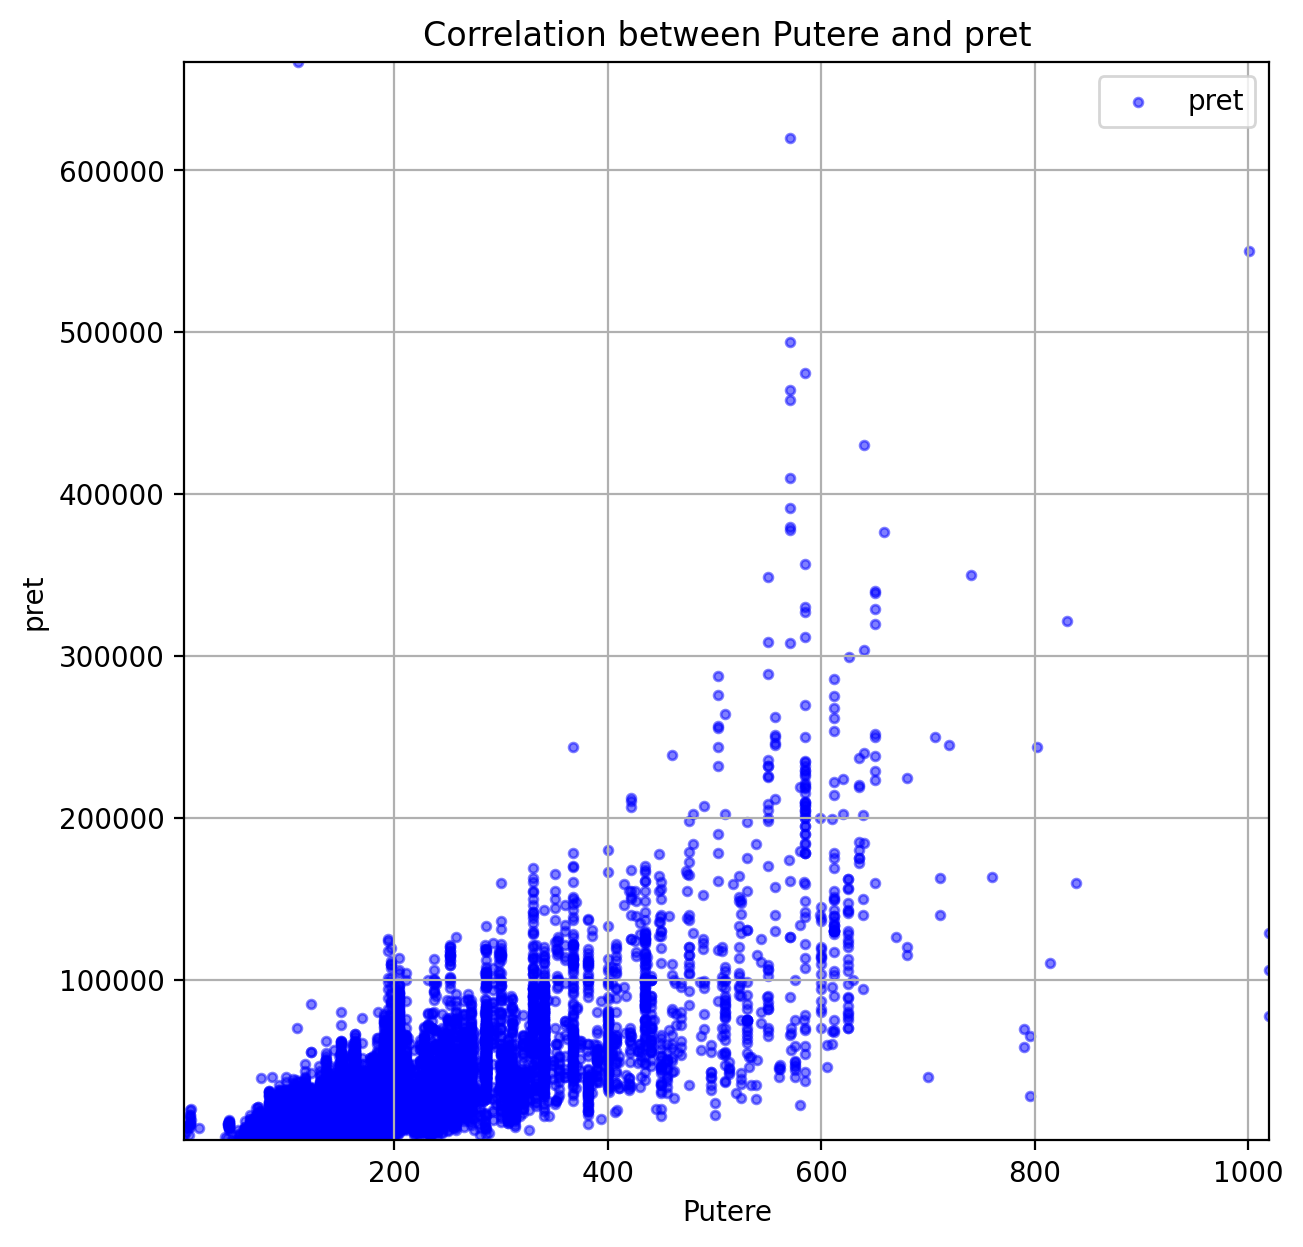

In [16]:
EDA_analyzer.plot_graph(df, 'Putere', 'pret')

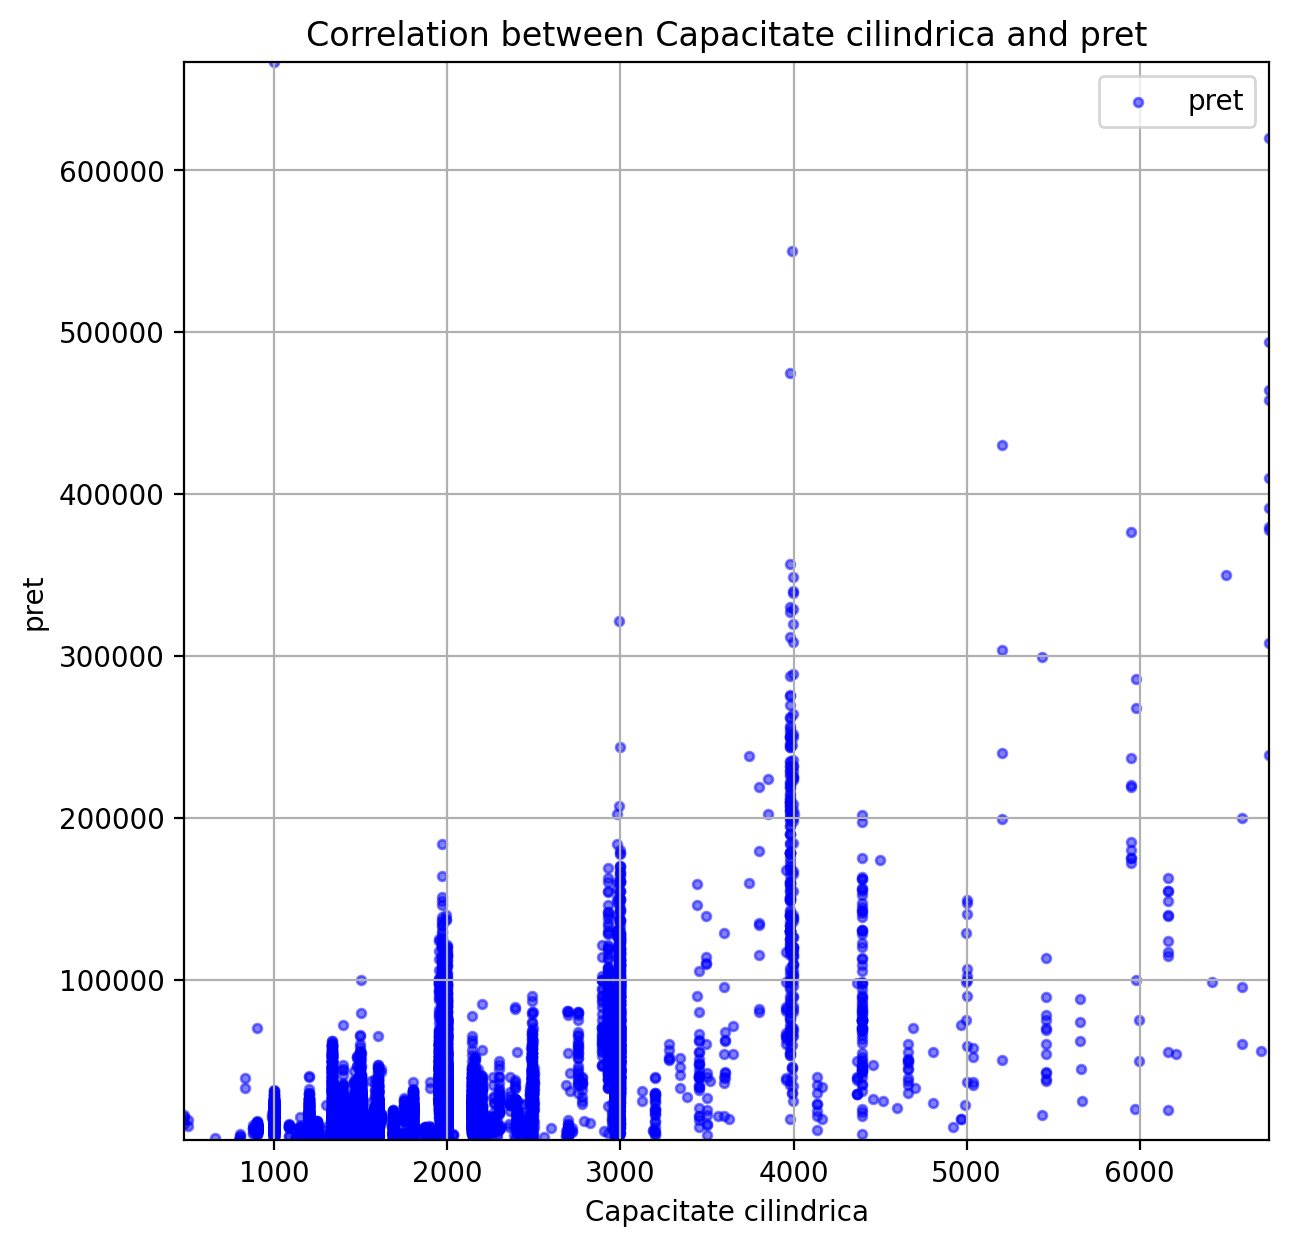

In [17]:
EDA_analyzer.plot_graph(df, 'Capacitate cilindrica', 'pret')

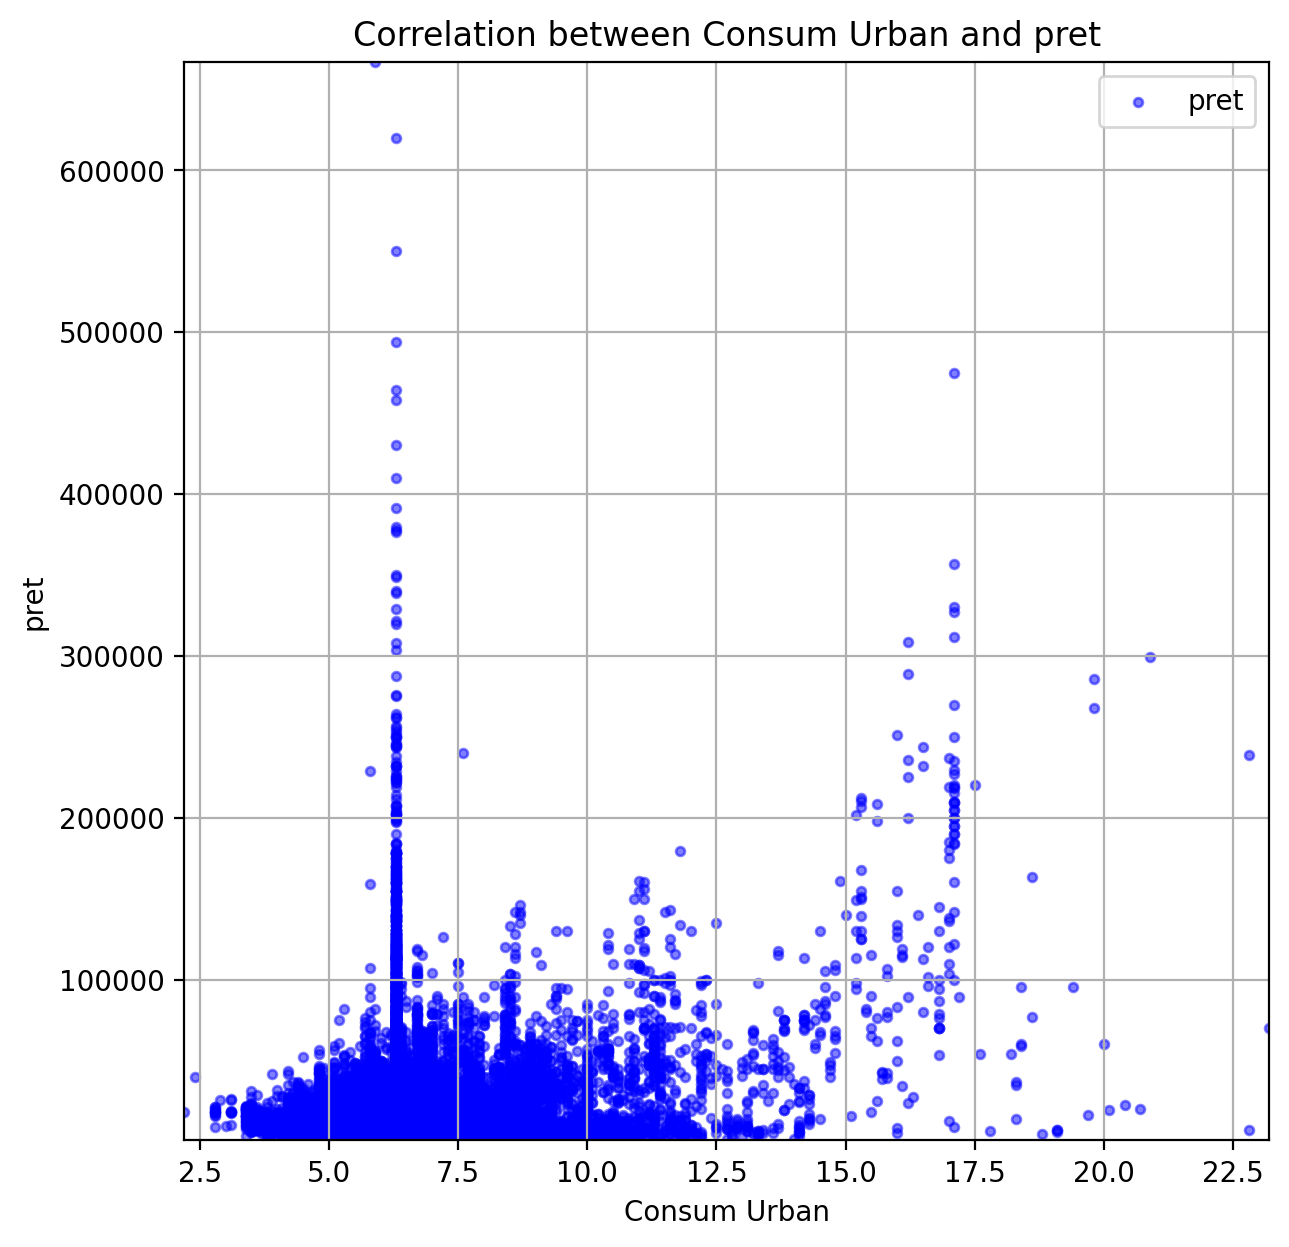

In [18]:
EDA_analyzer.plot_graph(df, 'Consum Urban', 'pret')

#### 3. K-Folds Cross Validation

In order to predict how well our model will perform, we need to apply cross-validation on the dataset.

In [19]:
k_fold_cross_validation = KFoldCrossValidation(df)
print(df.columns)
df = k_fold_cross_validation.df
train_buckets = k_fold_cross_validation.leq_range_buckets("pret", [5000, 15000])
for bucket in train_buckets:
    print(
       f"`Bucket: {bucket}` contains {len(train_buckets[bucket])} samples."
       f" Percentage of total: {len(train_buckets[bucket]) / len(df):.2%}"
    )

Index(['nume', 'pret', 'Oferit de', 'Are VIN (Serie sasiu)', 'Marca', 'Model',
       'Versiune', 'Anul producției', 'Km', 'Combustibil', 'Putere',
       'Capacitate cilindrica', 'Transmisie', 'Consum Extraurban',
       'Cutie de viteze', 'Consum Urban', 'Tip Caroserie', 'Emisii CO2',
       'Numar de portiere', 'Culoare', 'Numar locuri', 'Se emite factura',
       'Eligibil pentru finantare', 'Primul proprietar (de nou)',
       'Fara accident in istoric', 'Carte de service', 'Stare',
       'VIN (serie sasiu)', 'Audio si tehnologie',
       'Confort si echipamente optionale',
       'Electronice si sisteme de asistenta', 'Siguranta', 'Generatie',
       'Norma de poluare', 'Optiuni culoare', 'Tara de origine',
       'Data primei inmatriculari', 'Performanta', 'Inmatriculat'],
      dtype='object')
`Bucket: <5000` contains 1491 samples. Percentage of total: 7.64%
`Bucket: <15000` contains 7199 samples. Percentage of total: 36.87%
`Bucket: >15000` contains 10836 samples. Percentage 

In [20]:
kfolds = k_fold_cross_validation.make_folds(train_buckets)
print(f"Number of buckets: {len(kfolds)}")
for bucket_name, bucket_kfolds in kfolds.items():
  print(f"Bucket: {bucket_name}")
  for idx, (train_idx, val_idx) in enumerate(bucket_kfolds):
    print(f"Fold: {idx}")
    print(f"Training indices: {train_idx}")
    print(f"Validation indices: {val_idx}")
    print()

Number of buckets: 4
Bucket: <5000
Fold: 0
Training indices: [ 299  300  301 ... 1488 1489 1490]
Validation indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 21

In [21]:
n_folds = 5
kfolds = k_fold_cross_validation.make_folds(train_buckets, n_splits=n_folds, shuffle=False)

train_dfs, test_dfs = k_fold_cross_validation.get_train_test_folds(train_buckets, kfolds, n_folds)
print(f"Number of folds: {len(train_dfs)}")
for idx, (train_df, test_df) in enumerate(zip(train_dfs, test_dfs)):
  print(f"Fold: {idx}")
  print(f"Training shape: {train_df.shape}")
  print(f"Testing shape: {test_df.shape}")
  print()

print(df.columns)

Number of folds: 5
Fold: 0
Training shape: (15619, 39)
Testing shape: (3907, 39)

Fold: 1
Training shape: (15621, 39)
Testing shape: (3905, 39)

Fold: 2
Training shape: (15621, 39)
Testing shape: (3905, 39)

Fold: 3
Training shape: (15621, 39)
Testing shape: (3905, 39)

Fold: 4
Training shape: (15622, 39)
Testing shape: (3904, 39)

Index(['nume', 'pret', 'Oferit de', 'Are VIN (Serie sasiu)', 'Marca', 'Model',
       'Versiune', 'Anul producției', 'Km', 'Combustibil', 'Putere',
       'Capacitate cilindrica', 'Transmisie', 'Consum Extraurban',
       'Cutie de viteze', 'Consum Urban', 'Tip Caroserie', 'Emisii CO2',
       'Numar de portiere', 'Culoare', 'Numar locuri', 'Se emite factura',
       'Eligibil pentru finantare', 'Primul proprietar (de nou)',
       'Fara accident in istoric', 'Carte de service', 'Stare',
       'VIN (serie sasiu)', 'Audio si tehnologie',
       'Confort si echipamente optionale',
       'Electronice si sisteme de asistenta', 'Siguranta', 'Generatie',
       

,pret,Anul producției,Km,Putere,Capacitate cilindrica,Consum Extraurban,Consum Urban
0,9999.0,2010,225000.0,140.0,1968.0,5.5,7.9
1,3150.0,2002,160000.0,100.0,1598.0,4.7,9.6
2,17790.0,2023,15320.0,91.0,999.0,4.7,6.3
3,24990.0,2016,145000.0,190.0,1995.0,4.9,5.3
4,9790.0,2014,218000.0,109.0,1461.0,4.7,4.8
...,...,...,...,...,...,...,...
19521,4490.0,2011,205275.0,112.0,1560.0,4.2,5.9
19522,8490.0,2014,204600.0,109.0,1461.0,4.3,4.5
19523,10990.0,2011,216286.0,190.0,2179.0,5.8,8.7
19524,37450.0,2018,106458.0,258.0,2993.0,5.7,7.1


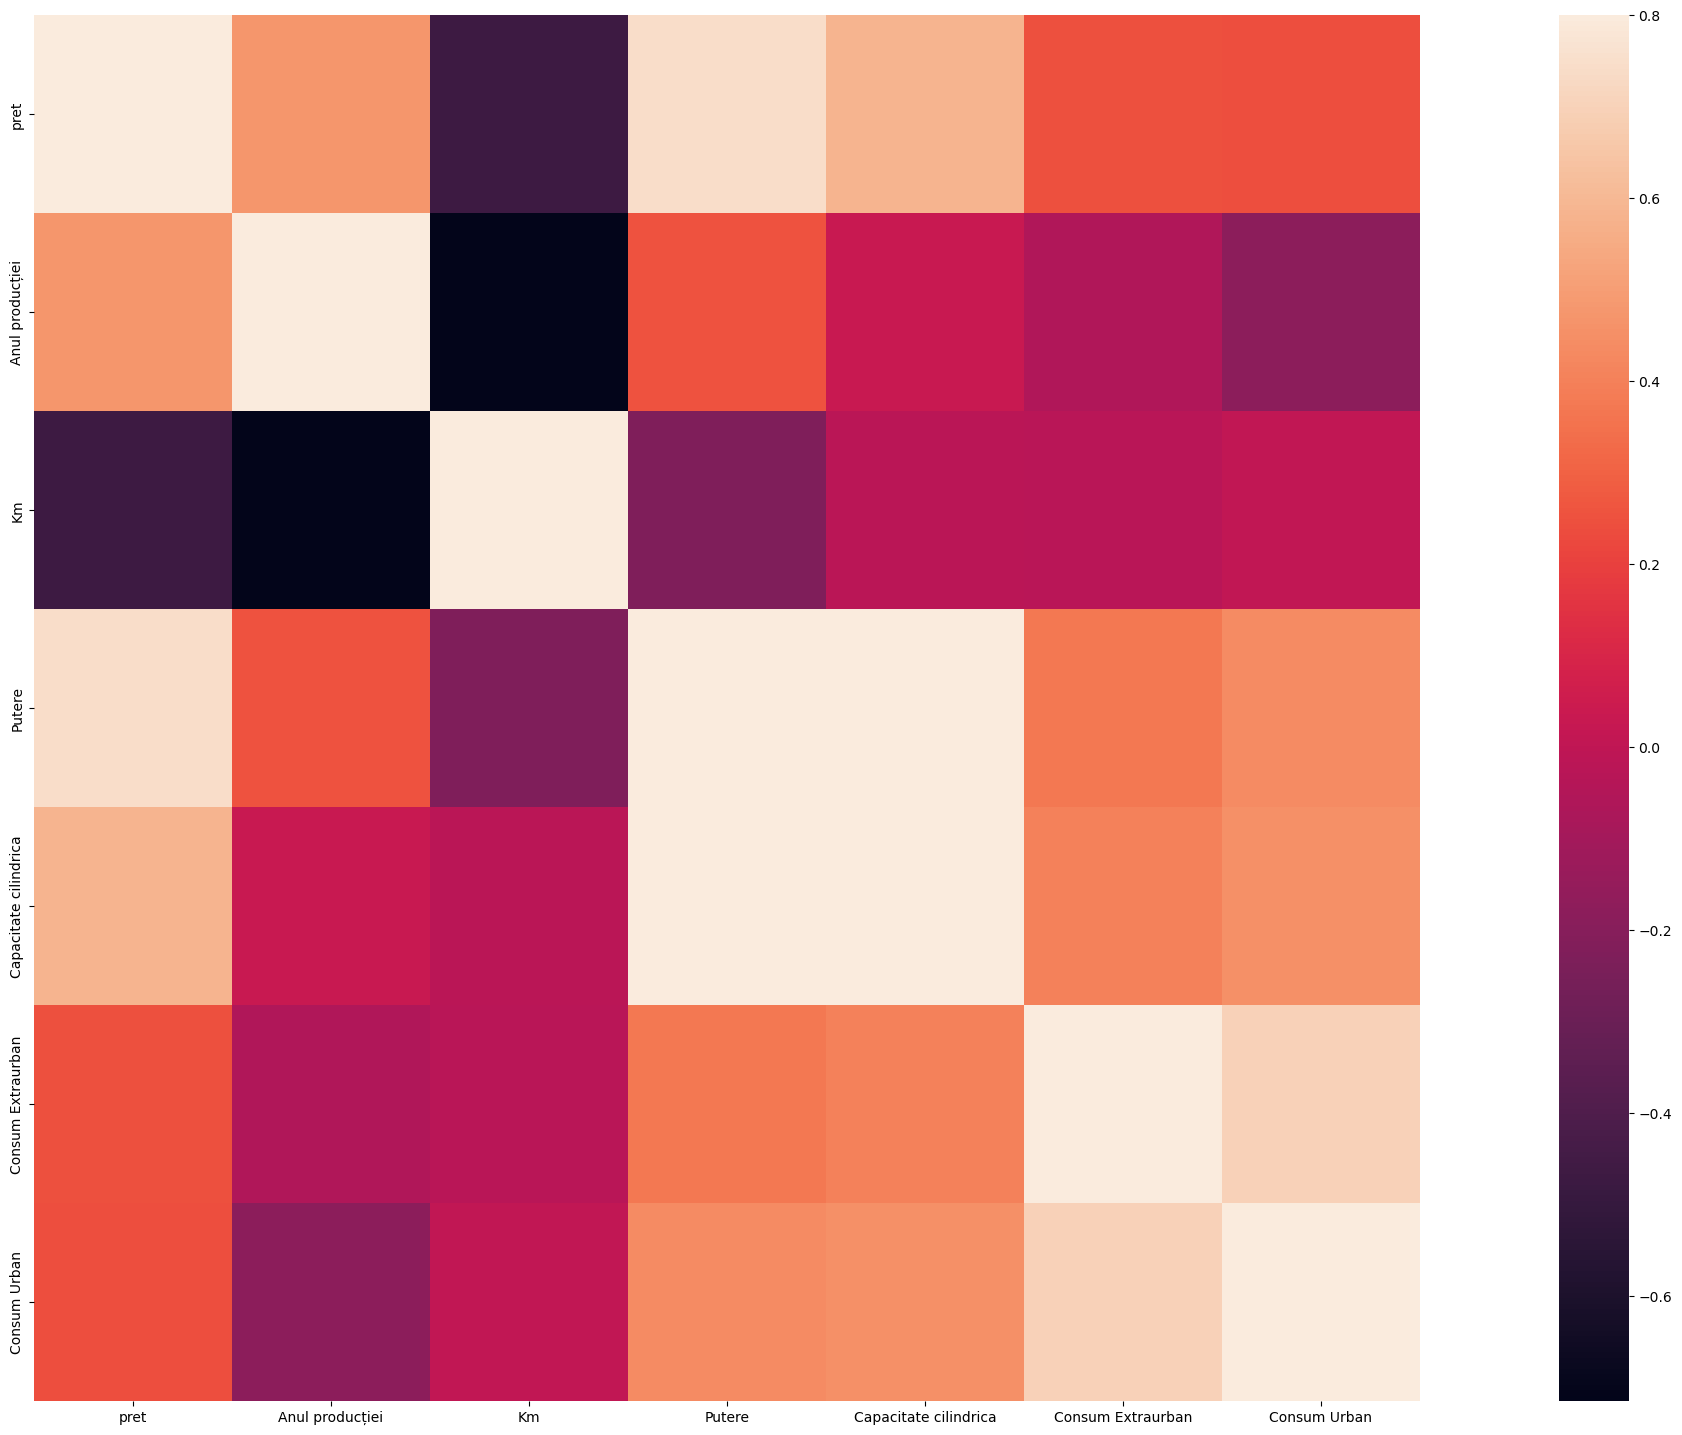

In [22]:
k_fold_cross_validation.plot_correlation_with_price()

In [23]:
total_null = df.isnull().sum().sort_values(ascending=False)
percent_null = df.isnull().sum() / df.isnull().count() * 100
percent_null = percent_null.sort_values(ascending=False)
null_data = pd.concat([total_null, percent_null], axis=1, keys=['Total', 'Percent'])
null_data.head(100)

,Total,Percent
nume,0,0.0
Confort si echipamente optionale,0,0.0
Eligibil pentru finantare,0,0.0
Primul proprietar (de nou),0,0.0
Fara accident in istoric,0,0.0
Carte de service,0,0.0
Stare,0,0.0
VIN (serie sasiu),0,0.0
Audio si tehnologie,0,0.0
Electronice si sisteme de asistenta,0,0.0


#### 5. Finally, we run our Regression algorithms

In [24]:
num_dataframe = df.select_dtypes(include='number')

n_folds = 5
target = 'pret'
feature_columns = num_dataframe.columns.tolist()
feature_columns.remove('pret')
num_dataframe = num_dataframe.drop(columns='pret')
target = df['pret']
num_dataframe['id'] = car_ids
print(target)
print(num_dataframe.columns)
features = df[feature_columns]

linear_regression = LinearRegression(num_dataframe, features, target, n_folds)



0         9999.0
1         3150.0
2        17790.0
3        24990.0
4         9790.0
          ...   
19521     4490.0
19522     8490.0
19523    10990.0
19524    37450.0
19525    39550.0
Name: pret, Length: 19526, dtype: float64
Index(['Anul producției', 'Km', 'Putere', 'Capacitate cilindrica',
       'Consum Extraurban', 'Consum Urban', 'Emisii CO2', 'Numar de portiere',
       'Numar locuri', 'id'],
      dtype='object')


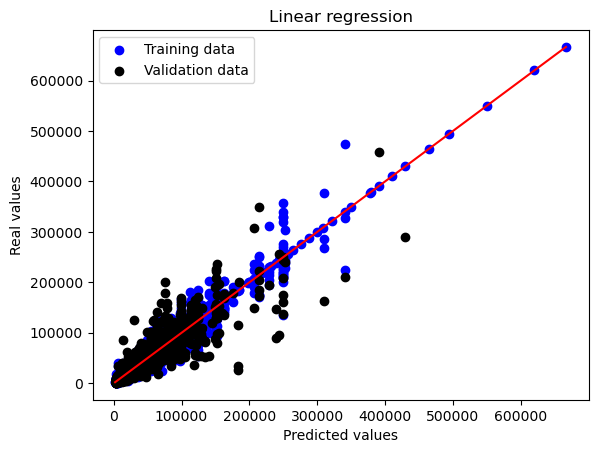

Model: Decision Tree
Best Params: {'max_depth': 10}
MSE: 229834693.71438223
R-squared: 0.9540246684829402

Train RMSE: 14726.918749624912

Test RMSE: 16504.252714117072



{'model_name': 'Decision Tree',
 'best_params': {'max_depth': 10},
 'mean_mse': 229834693.71438223,
 'std_mse': 71483532.55019464,
 'r_squared': 0.9540246684829402,
 'train_rmse': 14726.918749624912,
 'test_rmse': 16504.252714117072,
 'train_results':            car_id  predicted_price
 18772  7053510378     15231.665796
 5292   7050994891      9592.693182
 11301  7052854737      7089.223333
 14637  7053379657      9592.693182
 5596   7052854465     12785.456897
 ...           ...              ...
 2175   7053192659     13105.578723
 87     7050905703    101595.250000
 11595  7053200809     16400.804348
 6462   7051948839      5744.387097
 12798  7052752515     44928.952941
 
 [14644 rows x 2 columns],
 'test_results':            car_id  predicted_price
 191    7053186477      9977.961644
 8247   7053059159     21222.034286
 236    7049411682     17355.158879
 6272   7053114855     63842.083148
 17873  7053528830      6917.996416
 ...           ...              ...
 5860   7053146468  

In [25]:
linear_regression.run_regression("Decision Tree")

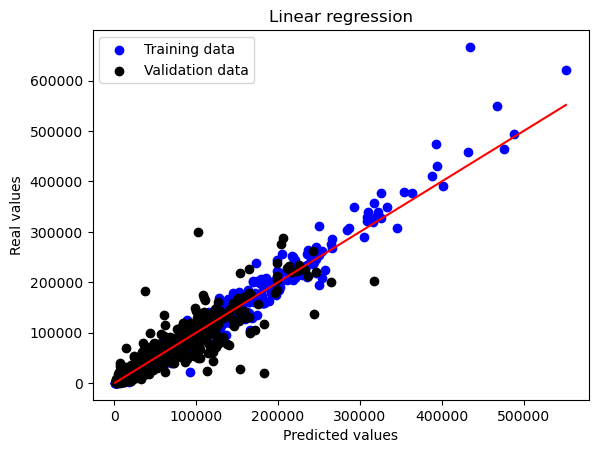

Model: Random Forest
Best Params: {'n_estimators': 100}
MSE: 131013802.46360095
R-squared: 0.9831139585414569

Train RMSE: 11573.057997670176

Test RMSE: 10380.875258081112



{'model_name': 'Random Forest',
 'best_params': {'n_estimators': 100},
 'mean_mse': 131013802.46360095,
 'std_mse': 47515896.34884814,
 'r_squared': 0.9831139585414569,
 'train_rmse': 11573.057997670176,
 'test_rmse': 10380.875258081112,
 'train_results':            car_id  predicted_price
 3705   7052209707       16103.3900
 17394  7053505810        3536.5550
 14112  7053305732      103525.5250
 10850  7052156990       26104.7500
 5540   7052159931       36385.4900
 ...           ...              ...
 2757   7052772430       21808.1750
 2247   7053188043       15358.3728
 14342  7053306404       61294.9600
 11190  7047035172        5523.6200
 11289  7053200254       15028.2400
 
 [14644 rows x 2 columns],
 'test_results':            car_id  predicted_price
 1021   7053112812       24867.4150
 13521  7052663322       29355.4450
 8989   7052965545        9177.4850
 5922   7042595520       31506.7150
 7669   7053077884       12175.5250
 ...           ...              ...
 6263   70532016

In [26]:
linear_regression.run_regression("Random Forest")

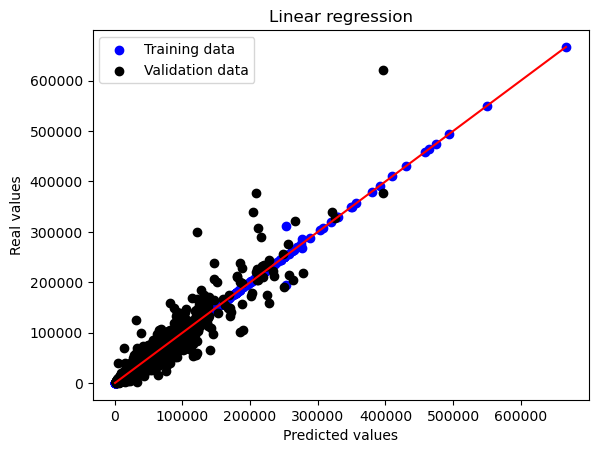

Model: Extra Trees
Best Params: {'n_estimators': 50}
MSE: 131158603.03113556
R-squared: 0.999158436156531

Train RMSE: 11341.041815434144

Test RMSE: 11320.496035044218



{'model_name': 'Extra Trees',
 'best_params': {'n_estimators': 50},
 'mean_mse': 131158603.03113556,
 'std_mse': 47261346.852985315,
 'r_squared': 0.999158436156531,
 'train_rmse': 11341.041815434144,
 'test_rmse': 11320.496035044218,
 'train_results':            car_id  predicted_price
 18387  7053274297          25000.0
 17647  7053374060           6200.0
 11235  7053112280         154900.0
 15005  7053513584          14999.0
 9370   7053109548          11000.0
 ...           ...              ...
 19508  7053448794          24000.0
 10053  7052933609          20000.0
 1127   7052387692         122899.0
 7812   7053187812          39989.0
 10570  7053130272         159900.0
 
 [14644 rows x 2 columns],
 'test_results':            car_id  predicted_price
 6480   7053188715     22002.240000
 16333  7053378446     62965.340000
 3793   7053151912     20444.340000
 15676  7053389120     13048.210000
 7650   7052714997     81527.220000
 ...           ...              ...
 14174  7053539652 

In [27]:
linear_regression.run_regression("Extra Trees")

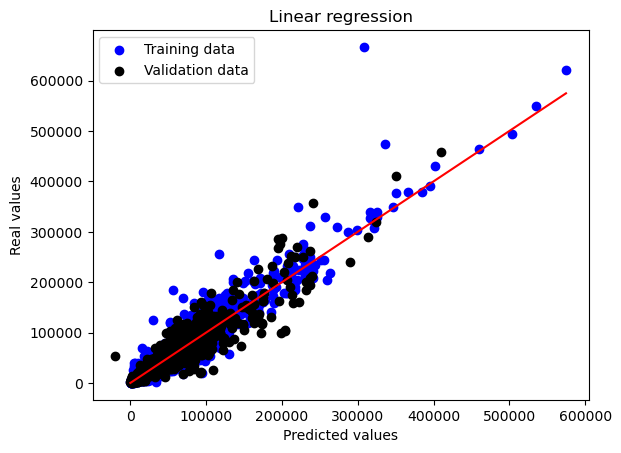

Model: Gradient Boosting
Best Params: {'n_estimators': 200}
MSE: 153699053.8462295
R-squared: 0.922111446276551

Train RMSE: 12116.279716378416

Test RMSE: 12726.35548421258



{'model_name': 'Gradient Boosting',
 'best_params': {'n_estimators': 200},
 'mean_mse': 153699053.8462295,
 'std_mse': 83536291.09034714,
 'r_squared': 0.922111446276551,
 'train_rmse': 12116.279716378416,
 'test_rmse': 12726.35548421258,
 'train_results':            car_id  predicted_price
 2684   7043919863     33113.482388
 14083  7053388133     18713.227789
 8338   7052976042     61956.257651
 11637  7053132496     81788.465989
 1147   7052310535     10428.964991
 ...           ...              ...
 251    7053162983     12577.309658
 4688   7052222258     41687.980246
 1368   7053159986     46024.874723
 12147  7053112810     15972.615826
 19120  7053082091     37280.774692
 
 [14644 rows x 2 columns],
 'test_results':            car_id  predicted_price
 16763  7052679259     19547.500426
 10313  7052208757     16387.119269
 3150   7051969363     18199.504609
 8346   7053100520     35012.930199
 529    7053008535     84252.532524
 ...           ...              ...
 13834  7053524

In [28]:
linear_regression.run_regression("Gradient Boosting")

In [29]:
import os

output_dir = 'predictions'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### 6. Applying operations on the test dataset

In [30]:
data_cleaner_test = DataCleaning('assets/auto_test_leaderboard.csv')
df_test = data_cleaner_test.df

df_test = data_cleaner_test.delete_columns_with_nans(df_test)
df_test = data_cleaner_test.fill_nan_with_frequent(df_test)

Deleted column 'Autonomie' with 8811 NaN values (more than 66.0% of the rows)
Deleted column 'Consum mediu' with 8870 NaN values (more than 66.0% of the rows)
Deleted column 'Capacitate baterie' with 8814 NaN values (more than 66.0% of the rows)
Deleted column 'Contract baterie' with 8853 NaN values (more than 66.0% of the rows)
Deleted column 'Data primei inmatriculari' with 8977 NaN values (more than 66.0% of the rows)
Deleted column 'Vehicule electrice' with 7817 NaN values (more than 66.0% of the rows)
Deleted column 'sau in limita a' with 7885 NaN values (more than 66.0% of the rows)
Deleted column 'Garantie dealer (inclusa in pret)' with 6913 NaN values (more than 66.0% of the rows)
Deleted column 'Garantie de la producator pana la' with 8457 NaN values (more than 66.0% of the rows)
Deleted column 'Tuning' with 8879 NaN values (more than 66.0% of the rows)
Deleted column 'Masina de epoca' with 8960 NaN values (more than 66.0% of the rows)
Deleted column 'Consum Mixt' with 8920 Na

c:\Users\Luca Petrescu\Desktop\Master\Anul 1\Semestrul 2\DMDA\Curs\Tema 2\Assignment_2_Luca_Petrescu\vehicle_regresion\DataCleaning.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(most_frequent_value, inplace=True)


In [31]:
numeric_columns = data_cleaner.df.select_dtypes(include=['number'])
numeric_columns_with_nan = numeric_columns.columns[numeric_columns.isna().any()].tolist()
numeric_df_with_nan = df_test[numeric_columns_with_nan]
numeric_df_with_nan.info()
numeric_dataframe = pd.DataFrame(numeric_df_with_nan)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8977 entries, 0 to 8976
Empty DataFrame


In [32]:
object_columns = data_cleaner.df.select_dtypes(include=['object'])
object_columns_with_nan = object_columns.columns[object_columns.isna().any()].tolist()
object_df_with_nan = df_test[object_columns_with_nan]
object_df_with_nan.info()
object_dataframe = pd.DataFrame(object_df_with_nan)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8977 entries, 0 to 8976
Empty DataFrame


In [33]:
df_test = data_cleaner.fill_nan_with_median(df_test)

c:\Users\Luca Petrescu\Desktop\Master\Anul 1\Semestrul 2\DMDA\Curs\Tema 2\Assignment_2_Luca_Petrescu\vehicle_regresion\DataCleaning.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(median_value, inplace=True)


In [34]:
car_ids_test = df_test["id"]
print(car_ids)
df_test = df_test.drop(columns=['id', 'data'])

num_dataframe = df_test.select_dtypes(include='number')
print(num_dataframe.columns)
n_folds = 5
target = 'pret'
feature_columns = num_dataframe.columns.tolist()
# feature_columns.remove('pret')
# target = df['pret']
num_dataframe['id'] = car_ids
print(target)

new_data_features = df_test[feature_columns]

0        7053131628
1        7053116553
2        7052933182
3        7053100111
4        7053209893
            ...    
19521    7053128100
19522    7053125121
19523    7053262542
19524    7051451034
19525    7053187847
Name: id, Length: 19526, dtype: int64
Index(['Anul producției', 'Km', 'Putere', 'Numar de portiere', 'Numar locuri',
       'Capacitate cilindrica', 'Consum Extraurban', 'Consum Urban',
       'Emisii CO2'],
      dtype='object')
pret


In [35]:
loaded_model = linear_regression.load_model('Decision Tree_model.pk1')
predictions = LinearRegression.predict(loaded_model, new_data_features)

new_data_predictions = pd.DataFrame({'id': new_data_features['id'], 'value': predictions})

output_filepath = os.path.join(output_dir, 'decision_tree_new_data_predictions.csv')
new_data_predictions.to_csv(output_filepath, index=False)

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [ ]:
loaded_model = linear_regression.load_model('Random Forest_model.pk1')
predictions = LinearRegression.predict(loaded_model, new_data_features)

new_data_predictions = pd.DataFrame({'id': new_data_features['id'], 'value': predictions})

output_filepath = os.path.join(output_dir, 'random_forest_new_data_predictions.csv')
new_data_predictions.to_csv(output_filepath, index=False)

In [ ]:
loaded_model = linear_regression.load_model('Extra Trees_model.pk1')
predictions = LinearRegression.predict(loaded_model, new_data_features)

new_data_predictions = pd.DataFrame({'id': new_data_features['id'], 'value': predictions})

output_filepath = os.path.join(output_dir, 'extra_trees_new_data_predictions.csv')
new_data_predictions.to_csv(output_filepath, index=False)

In [ ]:
loaded_model = linear_regression.load_model('Gradient Boosting_model.pk1')
predictions = LinearRegression.predict(loaded_model, new_data_features)

new_data_predictions = pd.DataFrame({'id': new_data_features['id'], 'value': predictions})

output_filepath = os.path.join(output_dir, 'gradient_boosting_new_data_predictions.csv')
new_data_predictions.to_csv(output_filepath, index=False)